# Describing "bank-additional-full"

   # Input variables:
   `bank client data:`  
   1 - **age** (numeric)  
   2 - **job** : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")  
   3 - **marital** : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)  
   4 - **education** (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")  
   5 - **default**: has credit in default? (categorical: "no","yes","unknown")  
   6 - **housing**: has housing loan? (categorical: "no","yes","unknown")  
   7 - **loan**: has personal loan? (categorical: "no","yes","unknown")  
   # related with the last contact of the current campaign:  
   8 - **contact**: contact communication type (categorical: "cellular","telephone")   
   9 - **month**: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  10 - **day_of_week**: last contact day of the week (categorical: "mon","tue","wed","thu","fri")  
  11 - **duration**: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.  
   # other attributes:  
  12 - **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  13 - **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
  14 - **previous**: number of contacts performed before this campaign and for this client (numeric) 
  15 - **poutcome**: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")  
   # social and economic context attributes  
  16 - **emp.var.rate**: employment variation rate - quarterly indicator (numeric)  
  17 - **cons.price.idx**: consumer price index - monthly indicator (numeric)       
  18 - **cons.conf.idx**: consumer confidence index - monthly indicator (numeric)       
  19 - **euribor3m**: euribor 3 month rate - daily indicator (numeric)  
  20 - **nr.employed**: number of employees - quarterly indicator (numeric)  
    
   `Output variable (desired target):`  
  21 - **y** - has the client subscribed a term deposit? (binary: "yes","no")

## Standart steps in our EDA workflow

**Task 1** preparation of data for processing

1. download a sample of `bank-additional-full.csv`;
2. connect the necessary libraries;
3. display basic statistical information on numerical variables;
4. display the dimension of the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [2]:
def get_data(data_path: str, delimeter: str) -> pd.DataFrame:
    data = pd.read_csv(data_path,sep=delimeter)
    return data

dataset = get_data('bank-additional-full.csv',';')
dataset.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [3]:
print('Розмірність датасету: ',dataset.shape)

Розмірність датасету:  (41188, 21)


In [4]:
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


**Task 2** preparation of the target variable

In [5]:
def encode(df: pd.DataFrame, desirable_col: str) -> pd.Series:
    conditions = [
    (df[desirable_col] == 'no'),
    (df[desirable_col] == 'yes')]
    values = [0,1]
    df[desirable_col] = np.select(conditions, values)
    return df[desirable_col]

bank_target = encode(dataset,'y')
bank_target

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64

## Analysis of variables that characterize the bank's customers:

**Task 3** Determine all the attributes that characterize the bank's customers:


In [6]:
#print(dataset.columns)
bank_client = dataset.loc[:,'age':'loan']
bank_client

,age,job,marital,education,default,housing,loan
0,56,housemaid,married,basic.4y,no,no,no
1,57,services,married,high.school,unknown,no,no
2,37,services,married,high.school,no,yes,no
3,40,admin.,married,basic.6y,no,no,no
4,56,services,married,high.school,no,no,yes
...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no
41184,46,blue-collar,married,professional.course,no,no,no
41185,56,retired,married,university.degree,no,yes,no
41186,44,technician,married,professional.course,no,no,no


In [7]:
def unique_values(df: pd.DataFrame,col: str):
    print(col + ': ' + str(df[col].unique()) + '\n')
for i in bank_client.iloc[:,1:].columns:
    #print(i)
    unique_values(bank_client,str(i))

job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

marital: ['married' 'single' 'divorced' 'unknown']

education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

default: ['no' 'unknown' 'yes']

housing: ['no' 'yes' 'unknown']

loan: ['no' 'yes' 'unknown']



**Task 4** Analysis of the attribute `Age`:

Maximum value: 98 
Minimum value: 17
Missing values: 0


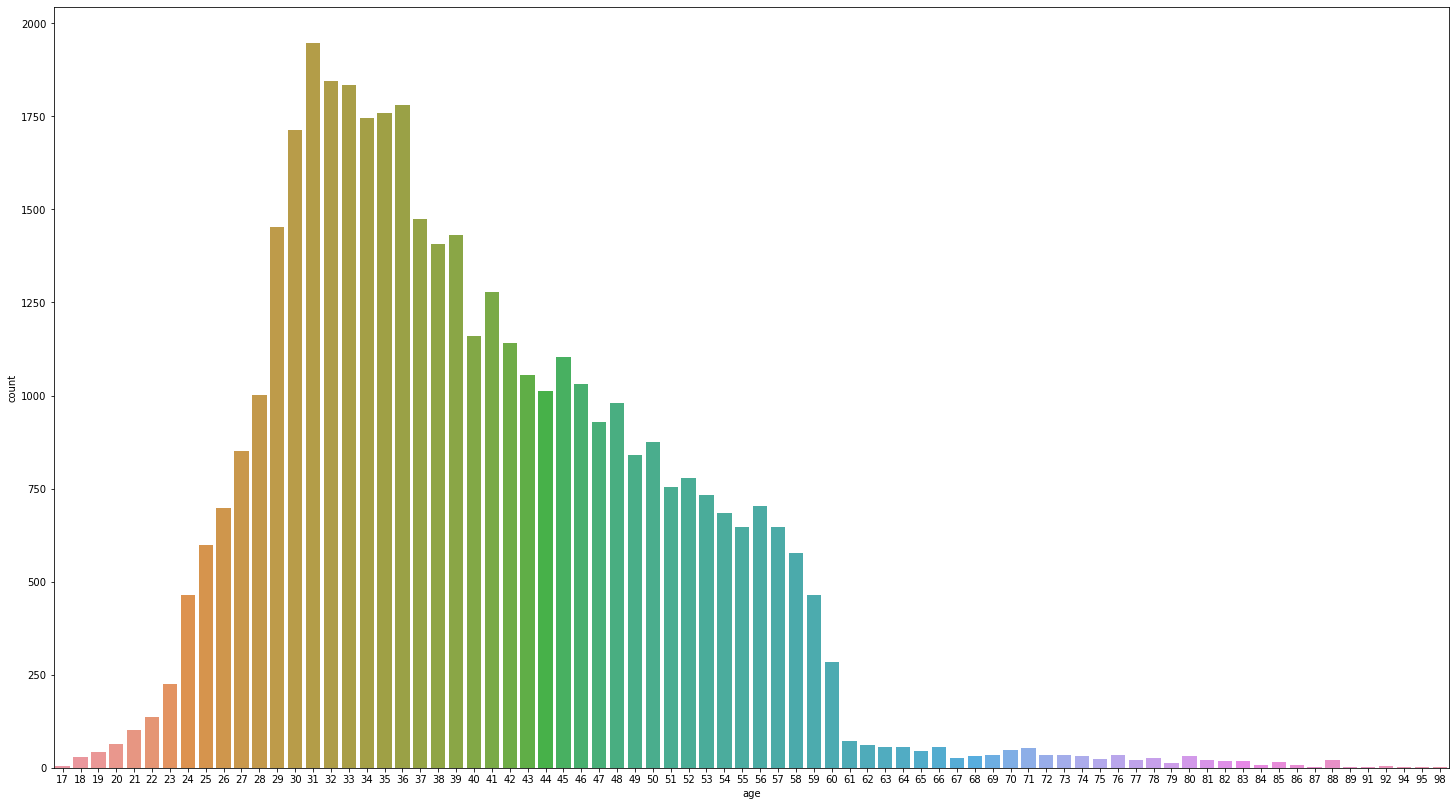

In [8]:
print('Maximum value: ' + str(bank_client.age.max()),'\nMinimum value: ' + str(bank_client.age.min()))
print('Missing values:',bank_client.age.isnull().sum())

plt.figure(figsize=(25,14))
sns.countplot(bank_client.age)
plt.show()

Skewness: 0.7846968157646645


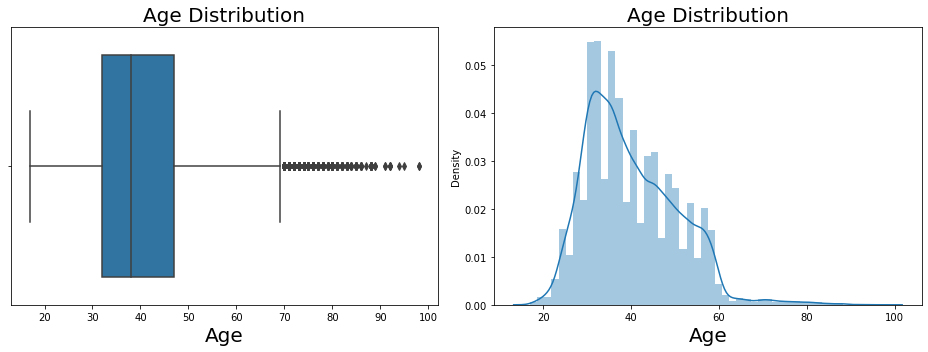

In [9]:
f, ax = plt.subplots(1,2,figsize=(13,5))

sns.boxplot(bank_client.age,ax=ax[0])
ax[0].set_xlabel('Age',fontsize=20)
ax[0].set_title('Age Distribution',fontsize=20)

sns.distplot(bank_client.age,ax=ax[1])
ax[1].set_xlabel('Age',fontsize=20)
ax[1].set_title('Age Distribution',fontsize=20)

plt.tight_layout()

print('Skewness:',bank_client.age.skew())

## Conclusions

1. Standard data preparation (connect libraries, download data, use methods to obtain statistics on dataset variables and size) for more comfortable further data processing

2. Define the target attribute (in the description of the dataset it was specified) and turn it into a numerical scale

3. According to the description of the dataset, defined variables related to clients, wrote them in a new df for easier further processing and derived all the unique values ​​of attributes, made f-tion and loop to automate the process of outputting these values ​​in a readable form.

4. We analyzed our age arbitrary and visualized it, the asymmetry coefficient is positive (> 0) so we can talk about the tail on the right, we can see it on the distribution graph.

**Task 5** Check the `Age` attribute for outliers:

In [10]:
def detect_outliers_with_interquantile_range(df: pd.DataFrame,
                                             column: str,
                                             low_percentile: int,
                                             high_percentile: int) -> pd.DataFrame:
    """
    Detecting outliers using interquantile range set manually

    df: pd.DataFrame to detect outliers
    column: target column
    low_percentile: lower bound between 0 and 100
    high_percentile: upper bound between 0 and 100

    returns: pd.DataFrame with detected outliers

    """

    sorted_data = np.sort(df[column])
    # Calculate Q1, Q2, Q3 and IQR.
    Q1 = np.percentile(sorted_data, low_percentile, interpolation='midpoint')
    Q3 = np.percentile(sorted_data, high_percentile, interpolation='midpoint')
    print('')
    print(f"Q1 {low_percentile} percentile of the given data: {Q1}")
    print('')
    print(f"Q3 {high_percentile} percentile of the given data: {Q3}")
    print('')
    print('----------------------------------------------------------')

    IQR = Q3 - Q1
    print('')
    print(f"Interquantile range: {IQR}")
    print('')
    print('----------------------------------------------------------')
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    print('')
    print(f" Lower bound: {low_lim}")
    print('')
    print(f" Upper bound: {up_lim}")
    print('')
    print('----------------------------------------------------------')
    outliers = df[(df[column] > up_lim) | (df[column] < low_lim)]
    print('')
    print(f"Outliers in the dataset:")
    display(outliers)


    return outliers

In [11]:
outliers = detect_outliers_with_interquantile_range(bank_client, 'age', 10, 90)


Q1 10 percentile of the given data: 28.0

Q3 90 percentile of the given data: 55.0

----------------------------------------------------------

Interquantile range: 27.0

----------------------------------------------------------

 Lower bound: -12.5

 Upper bound: 95.5

----------------------------------------------------------

Outliers in the dataset:


,age,job,marital,education,default,housing,loan
38452,98,retired,married,basic.4y,unknown,yes,no
38455,98,retired,married,basic.4y,unknown,yes,no


**Conclusions**

5. We have created our own f-tion, which on the basis of percentiles looks for probable outliers in our age column, as we see there are two people whose age has exceeded our upper limit of 95.5 years

**Task 6** Analysis of attributes `job`,` marital` and `education`:  

[]

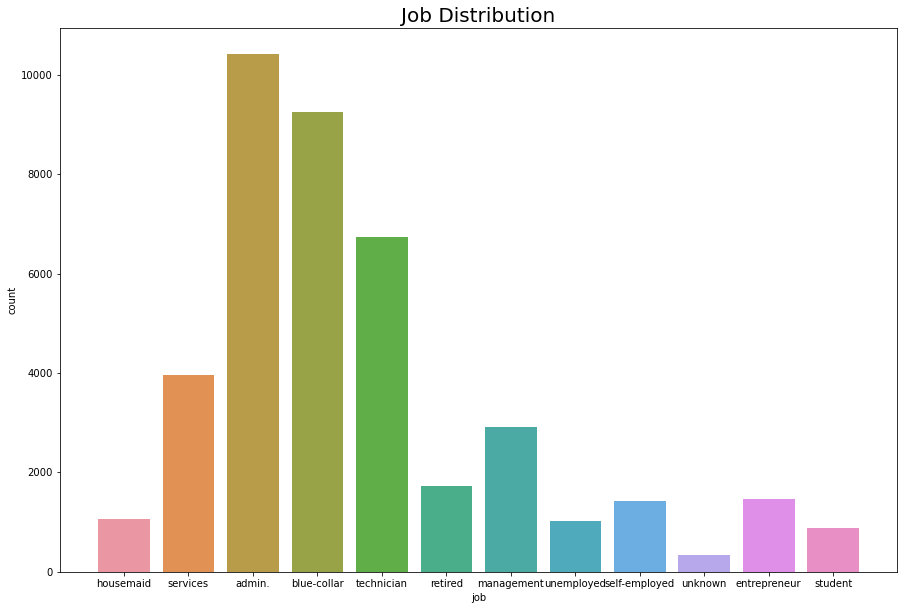

In [12]:
plt.figure(figsize=(15,10))

sns.countplot(data=bank_client, x="job").set_title('Job Distribution',fontsize=20)

plt.plot()

[]

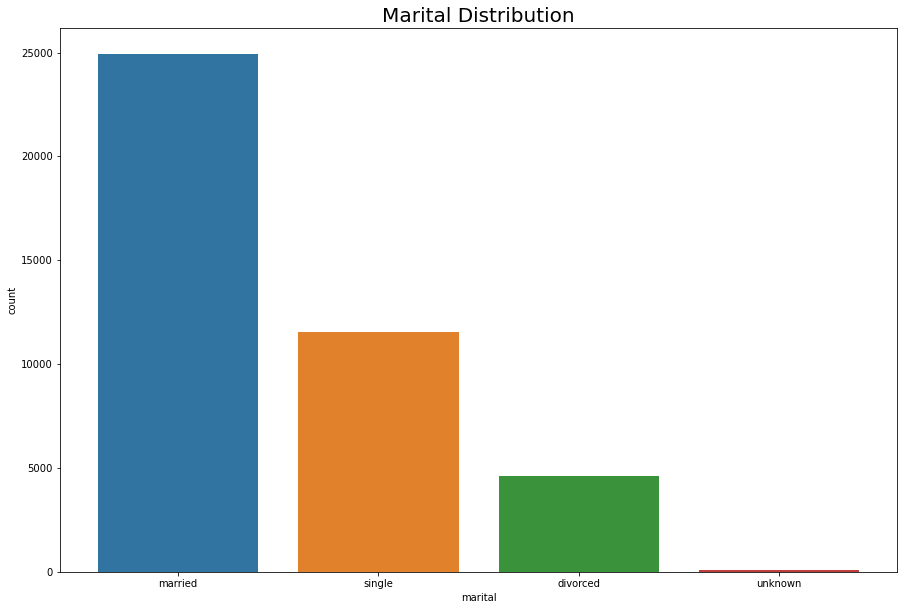

In [13]:
plt.figure(figsize=(15,10))

sns.countplot(data=bank_client, x="marital").set_title('Marital Distribution',fontsize=20)

plt.plot()

[]

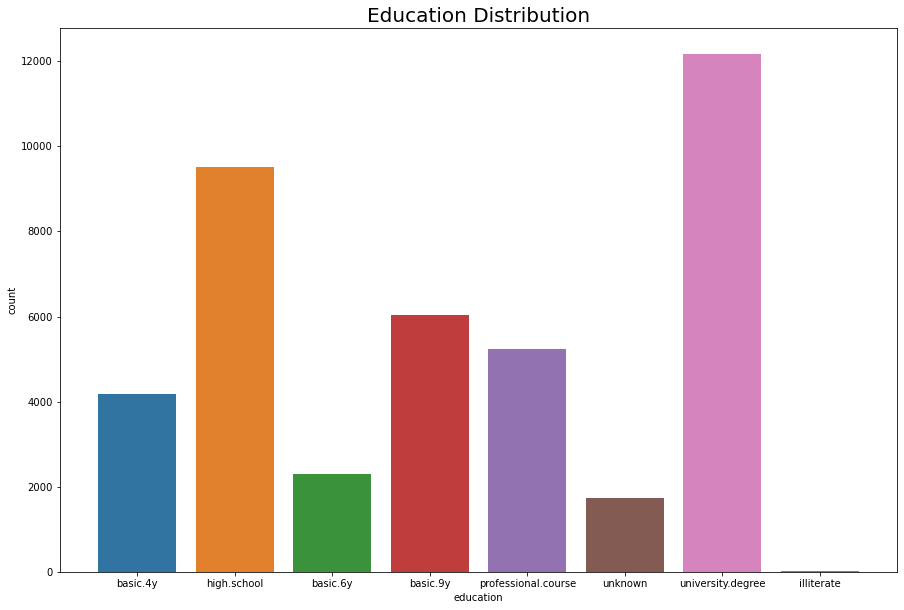

In [14]:
plt.figure(figsize=(15,10))

sns.countplot(data=bank_client, x="education").set_title('Education Distribution',fontsize=20)

plt.plot()

**Task 7** Analysis of attributes `default`,` housing` and `loan`:


[]

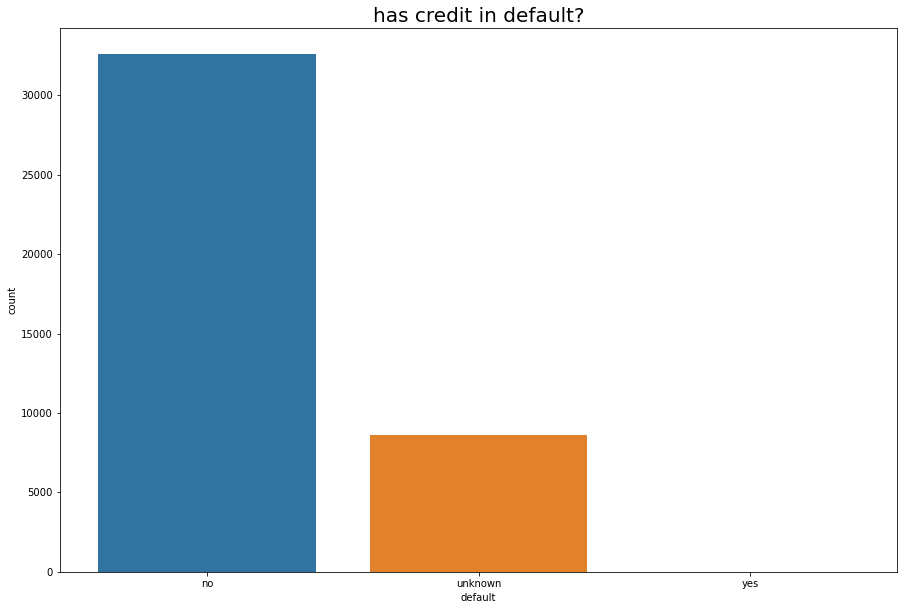

In [15]:
plt.figure(figsize=(15,10))

sns.countplot(data=bank_client, x="default").set_title('has credit in default?',fontsize=20)

plt.plot()

[]

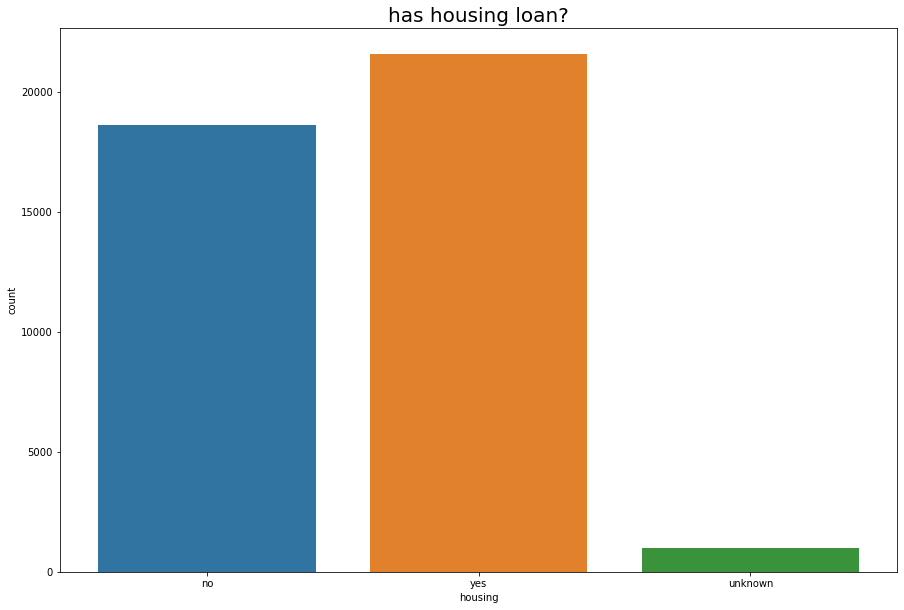

In [16]:
plt.figure(figsize=(15,10))

sns.countplot(data=bank_client, x="housing").set_title('has housing loan?',fontsize=20)

plt.plot()

[]

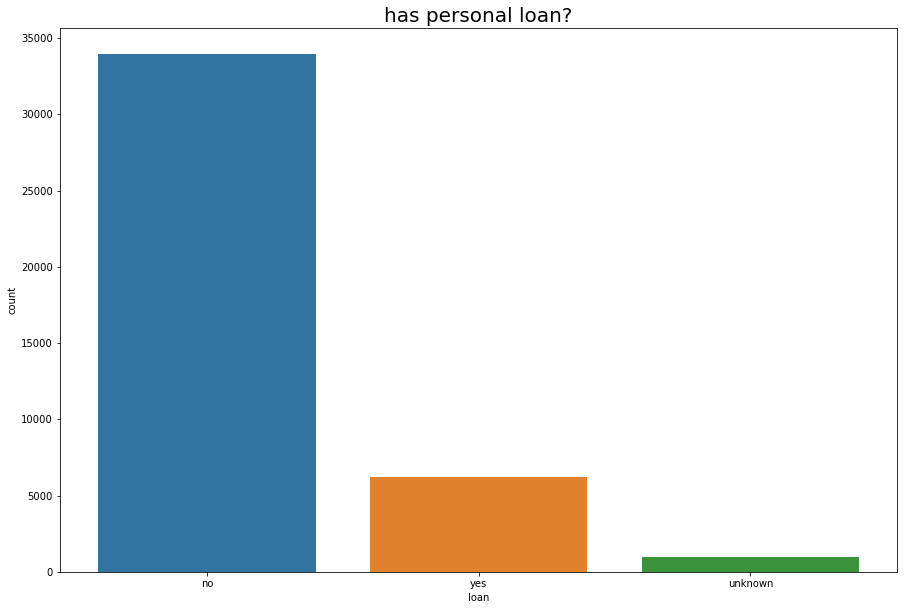

In [17]:
plt.figure(figsize=(15,10))

sns.countplot(data=bank_client, x="loan",).set_title('has personal loan?',fontsize=20)

plt.plot()

**Task 8** Variables **Jobs, Marital, Education, Default, Housing, Loan** transform into continuous variables:

In [18]:
def encode_categorical_columns(df: pd.DataFrame, categorical_cols: list) -> pd.DataFrame:
    """
    Function for encoding categorical features using LabelEncoder
    
    df: pd.DataFrame to encode
    categorical_cols: specified columns to encode
    
    returns: pd.DataFrame with encoded values
    """
    for col in categorical_cols:
      # Leaves NaN as it is.
        le = LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = le.fit_transform(not_null)
      
    return df

In [19]:
bank_client = encode_categorical_columns(bank_client, ['job', 'marital', 'education', 'default', 'housing',  'loan'])
bank_client

,age,job,marital,education,default,housing,loan
0,56,3,1,0,0,0,0
1,57,7,1,3,1,0,0
2,37,7,1,3,0,2,0
3,40,0,1,1,0,0,0
4,56,7,1,3,0,0,2
...,...,...,...,...,...,...,...
41183,73,5,1,5,0,2,0
41184,46,1,1,5,0,0,0
41185,56,5,1,6,0,2,0
41186,44,9,1,5,0,0,0


**Task 9** Transform the variable ** Age ** (using its quarter values):

In [20]:
def encode_age(dataframe: pd.DataFrame, age_col: str ) -> pd.DataFrame:
    """
    Function for encoding age column
    
    df: pd.DataFrame to encode
    age_col: age col to encode 
    """
    dataframe[age_col] = pd.qcut(dataframe[age_col], q=4)
    dataframe[age_col] = LabelEncoder().fit_transform(dataframe[age_col])      
    return dataframe

In [21]:
bank_client = encode_age(bank_client, 'age')
bank_client.age

0        3
1        3
2        1
3        2
4        3
        ..
41183    3
41184    2
41185    3
41186    2
41187    3
Name: age, Length: 41188, dtype: int64

### Conclusions

9. Transformed our variable age to the categorical type with four intervals from 16 to 98 years, and then these intervals from the categorical type were recoded into numerical, 4 intervals were replaced by 0,1,2,3. 

**Task 10** Allocate in a separate dataframe variables that characterize the relationship of customers with the bank;


In [22]:
print(dataset.columns)
bank_relat = dataset.loc[:,'contact':'duration']
print('\nHow much NaN are there:\n'+ str(bank_relat.isnull().sum()))
bank_relat

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

How much NaN are there:
contact        0
month          0
day_of_week    0
duration       0
dtype: int64


,contact,month,day_of_week,duration
0,telephone,may,mon,261
1,telephone,may,mon,149
2,telephone,may,mon,226
3,telephone,may,mon,151
4,telephone,may,mon,307
...,...,...,...,...
41183,cellular,nov,fri,334
41184,cellular,nov,fri,383
41185,cellular,nov,fri,189
41186,cellular,nov,fri,442


**Task 11** display unique values that contain the attributes `contact`,` month`, `day_of_week`

In [23]:
for i in bank_relat.iloc[:,:-1].columns:
    #print(i)
    unique_values(bank_relat,str(i))
    

contact: ['telephone' 'cellular']

month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']



**Task 12** Analysis of the attribute `duration`:

Carry out a visual analysis of the change `duration`:




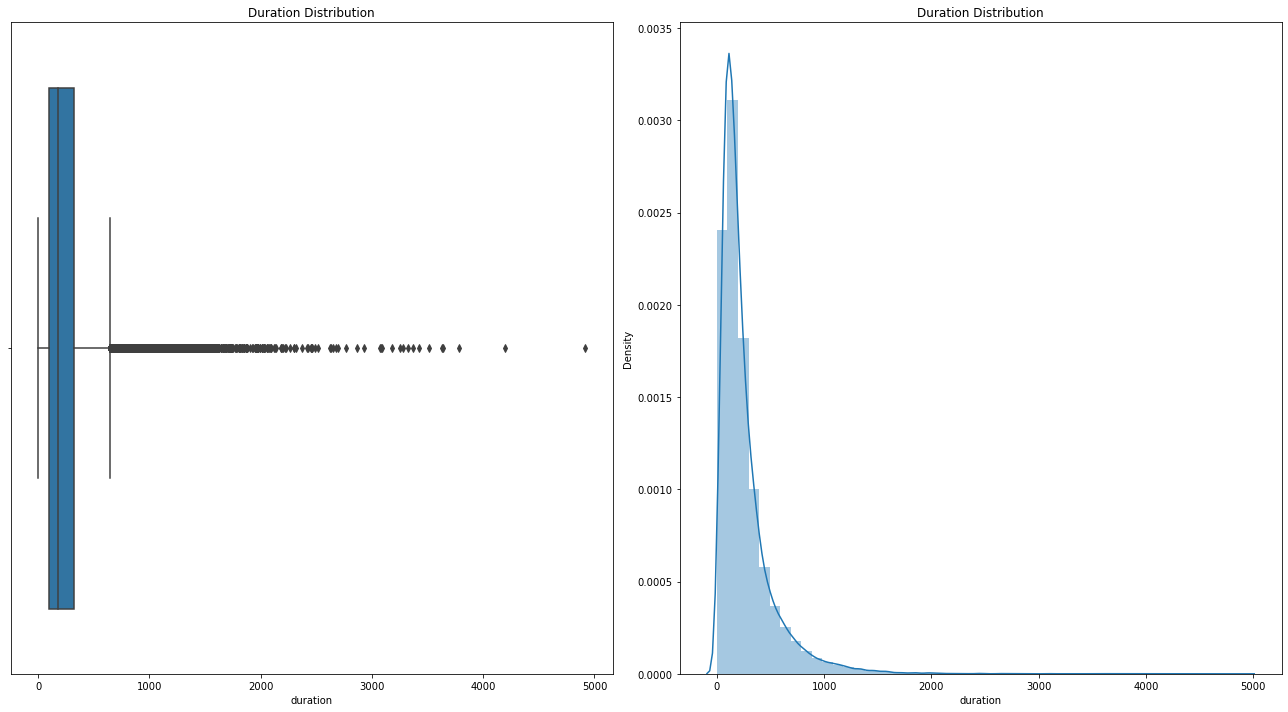

In [24]:
f, ax = plt.subplots(1,2,figsize=(18,10))
sns.boxplot(data=bank_relat,x='duration',ax=ax[0]).set_title('Duration Distribution')
sns.distplot(bank_relat['duration'],ax=ax[1]).set_title('Duration Distribution')
plt.tight_layout()

In [25]:
bank_relat.duration.skew()

3.263141255262832

**Task 13** Encode variables Contact, Month, Day of Week

In [26]:
bank_relat = encode_categorical_columns(bank_relat, ['contact', 'month', 'day_of_week'])
bank_relat

,contact,month,day_of_week,duration
0,1,6,1,261
1,1,6,1,149
2,1,6,1,226
3,1,6,1,151
4,1,6,1,307
...,...,...,...,...
41183,0,7,0,334
41184,0,7,0,383
41185,0,7,0,189
41186,0,7,0,442


**Task 14** Transform the variable **duration**, using its dwell values:

In [27]:
def encode_duration(dataframe: pd.DataFrame, duration_col: str ) -> pd.DataFrame:
    """
    Function for encoding duration column
    
    df: pd.DataFrame to encode
    duration_col: duration col to encode 
    """
  
    dataframe[duration_col] = pd.qcut(dataframe[duration_col], q=4)
    dataframe[duration_col] = LabelEncoder().fit_transform(dataframe[duration_col])      
    return dataframe

In [28]:
bank_relat = encode_duration(bank_relat, 'duration')
bank_relat

,contact,month,day_of_week,duration
0,1,6,1,2
1,1,6,1,1
2,1,6,1,2
3,1,6,1,1
4,1,6,1,2
...,...,...,...,...
41183,0,7,0,3
41184,0,7,0,3
41185,0,7,0,2
41186,0,7,0,3


**Task 15** Allocate the attributes of the social and economic context in a separate data frame

In [29]:
#print(dataset.columns)
bank_socec = dataset.loc[:,'emp.var.rate':'nr.employed']
bank_socec

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.1,93.994,-36.4,4.857,5191.0
1,1.1,93.994,-36.4,4.857,5191.0
2,1.1,93.994,-36.4,4.857,5191.0
3,1.1,93.994,-36.4,4.857,5191.0
4,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...
41183,-1.1,94.767,-50.8,1.028,4963.6
41184,-1.1,94.767,-50.8,1.028,4963.6
41185,-1.1,94.767,-50.8,1.028,4963.6
41186,-1.1,94.767,-50.8,1.028,4963.6


**Task 16** Select in a separate dataframe all other attributes attributes - `campaign`,` pdays`, `previous`,` poutcome`

In [30]:
bank_other = dataset.loc[:,'campaign':'poutcome']
bank_other

,campaign,pdays,previous,poutcome
0,1,999,0,nonexistent
1,1,999,0,nonexistent
2,1,999,0,nonexistent
3,1,999,0,nonexistent
4,1,999,0,nonexistent
...,...,...,...,...
41183,1,999,0,nonexistent
41184,1,999,0,nonexistent
41185,2,999,0,nonexistent
41186,1,999,0,nonexistent


**Task 17** Transform the `poutcome` attribute

In [31]:
#unique_values(bank_other,'poutcome')
bank_other.poutcome = bank_other.poutcome.map({'nonexistent':0,'failure':1,'success':2})
bank_other.poutcome 

0        0
1        0
2        0
3        0
4        0
        ..
41183    0
41184    0
41185    0
41186    0
41187    1
Name: poutcome, Length: 41188, dtype: int64

## Construction of classification models

**Task 18** Combine all the obtained blocks into one data frame and check that it contains only the columns needed for modeling

In [32]:
bank_final = pd.concat([bank_client, bank_relat, bank_socec, bank_other],axis=1)
bank_final.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'campaign', 'pdays', 'previous', 'poutcome'],
      dtype='object')

**Task 19** Divide the sample

In [33]:
def prepare_data_for_training(X: pd.DataFrame,
                              target: pd.Series,
                              test_size: float,
                              n_splits: int,
                              random_state: int):
    """
    Function that prepares data for training. Splits the data into train and test datasets and get k-folds for cross-validation

    X: pd.DataFrame with features
    target: target pd.Series
    test_size: the size of test datasets
    n_splits: number of cross-validation splits
    random_state: random state to reproduce the same split

    returns: X_train, X_test, y_train, y_test, k_fold
    """

    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=test_size, random_state=random_state, shuffle = True)
    k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    return X_train, X_test, y_train, y_test, k_fold

In [34]:
X_train, X_test, y_train, y_test, k_fold = prepare_data_for_training(bank_final, bank_target, 0.2, 10, 101)

In [35]:
def scale_the_data(X_train: pd.DataFrame, 
                   X_test: pd.DataFrame):
  
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)

    return X_train, X_test

In [36]:
X_train, X_test = scale_the_data(X_train, X_test)

## Logistic Regression

In [37]:
logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train)
logpred = logmodel.predict(X_test)


print(confusion_matrix(y_test, logpred))
print(round(accuracy_score(y_test, logpred),2)*100)
LOGCV = (cross_val_score(logmodel, X_test, y_test, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[7112  167]
 [ 633  326]]
90.0


## k-NN

k=1 86.84 (+/- 0.42)
k=2 89.31 (+/- 0.51)
k=3 89.00 (+/- 0.43)
k=4 89.83 (+/- 0.49)
k=5 89.76 (+/- 0.71)
k=6 90.24 (+/- 0.55)
k=7 90.14 (+/- 0.61)
k=8 90.37 (+/- 0.49)
k=9 90.32 (+/- 0.69)
k=10 90.39 (+/- 0.55)
k=11 90.39 (+/- 0.64)
k=12 90.39 (+/- 0.55)
k=13 90.45 (+/- 0.62)
k=14 90.42 (+/- 0.61)
k=15 90.47 (+/- 0.64)
k=16 90.51 (+/- 0.65)
k=17 90.55 (+/- 0.63)
k=18 90.54 (+/- 0.65)
k=19 90.56 (+/- 0.68)
k=20 90.51 (+/- 0.66)
k=21 90.56 (+/- 0.70)
k=22 90.53 (+/- 0.64)
k=23 90.54 (+/- 0.67)
k=24 90.54 (+/- 0.63)
k=25 90.58 (+/- 0.64)
The optimal number of neighbors is 24 with 90.6%


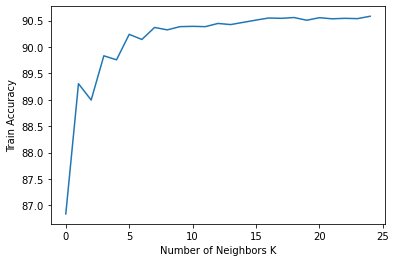

In [38]:
#Neighbors
neighbors = np.arange(0,25)

#Create empty list that will hold cv scores
cv_scores = []

#Perform 10-fold cross validation on training set for odd values of k:
for k in neighbors:
    k_value = k+1
    knn = KNeighborsClassifier(n_neighbors = k_value, weights='uniform', p=2, metric='euclidean')
    scores = model_selection.cross_val_score(knn, X_train, y_train, cv=k_fold, scoring='accuracy')
    cv_scores.append(scores.mean()*100)
    print("k=%d %0.2f (+/- %0.2f)" % (k_value, scores.mean()*100, scores.std()*100))

optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print ("The optimal number of neighbors is %d with %0.1f%%" % (optimal_k, cv_scores[optimal_k]))

plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()

In [39]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train,y_train)
knnpred = knn.predict(X_test)

print(confusion_matrix(y_test, knnpred))
print(round(accuracy_score(y_test, knnpred),2)*100)
KNNCV = (cross_val_score(knn, X_test, y_test, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[7159  120]
 [ 703  256]]
90.0


In [40]:
models = pd.DataFrame({
                'Models': ['LOGCV','KNNCV'],
                'Score':  [LOGCV,KNNCV]})

models.sort_values(by='Score', ascending=False)

,Models,Score
0,LOGCV,0.903378
1,KNNCV,0.899736


**Висновки по моделям (детальні)**

19. Models
- First, we divided our sample using the train_test_split function, divided the dataset into train and test
- Then applied logistic regression fit (X_train, y_train) and also predict on X_test and obtained an accuracy of 90% for LOGCV
- After that, we found the optimal number of k-neighbors = 24
- Similarly to the regression, we performed all the necessary steps for KNeighborsClassifier and saw that its accuracy is only slightly behind LOGCV, in the end we brought the accuracy of our models through a data frame for more comfortable reading.

### The end